In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns

import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.cuda.amp import autocast, GradScaler

import pandas as pd
from torch import nn, optim

from sklearn.metrics import confusion_matrix

In [15]:
from ConvNet import ConvNet
from DatasetEcg import DatasetECG

In [16]:
class_names = ('N', 'A', 'L', 'R', 'V')

In [17]:
train_pth = 'sh_dataset\\train\\'

val_pth = 'sh_dataset\\validation\\'

test_pth = 'sh_dataset\\test\\'

MODEL_PATH = 'models\\main_model_pr_l1\\ft_model60_1.pth'

In [18]:
test_ds_ecg = DatasetECG(test_pth)

1250


In [19]:
batch_size = 16

test_loader = torch.utils.data.DataLoader(
    test_ds_ecg, shuffle=True,
    batch_size=batch_size, drop_last=True
)

print(len(test_loader))

78


In [20]:
model = torch.load(MODEL_PATH)

In [21]:
#model.load_state_dict(torch.load('d_' + MODEL_PATH))

In [22]:
print(model)

ConvNet(
  (act): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 7, kernel_size=(5, 5), stride=(1, 1))
  (conv1): Conv2d(7, 13, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(13, 26, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(26, 52, kernel_size=(3, 3), stride=(1, 1))
  (linear0): Linear(in_features=6292, out_features=205, bias=True)
  (linear1): Linear(in_features=205, out_features=52, bias=True)
  (linear2): Linear(in_features=52, out_features=5, bias=True)
)


In [23]:
device = 'cuda'


In [24]:
model.eval()

correct=0
total=0

with torch.no_grad():
  for data in tqdm(test_loader):
    images,labels=data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)
    
    outputs=model(images)
        
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
  

accu=100.*correct/total
print('Accuracy: %.3f'%(accu)) 

100%|██████████| 78/78 [00:00<00:00, 81.66it/s]

Accuracy: 98.718


In [25]:
y_true = []
y_pred = []

for data in tqdm(test_loader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)

# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
dataframe

100%|██████████| 78/78 [00:00<00:00, 82.71it/s]


,N,A,L,R,V
N,249,0,0,0,0
A,3,240,0,0,6
L,0,0,249,0,1
R,0,0,0,250,0
V,1,4,1,0,244


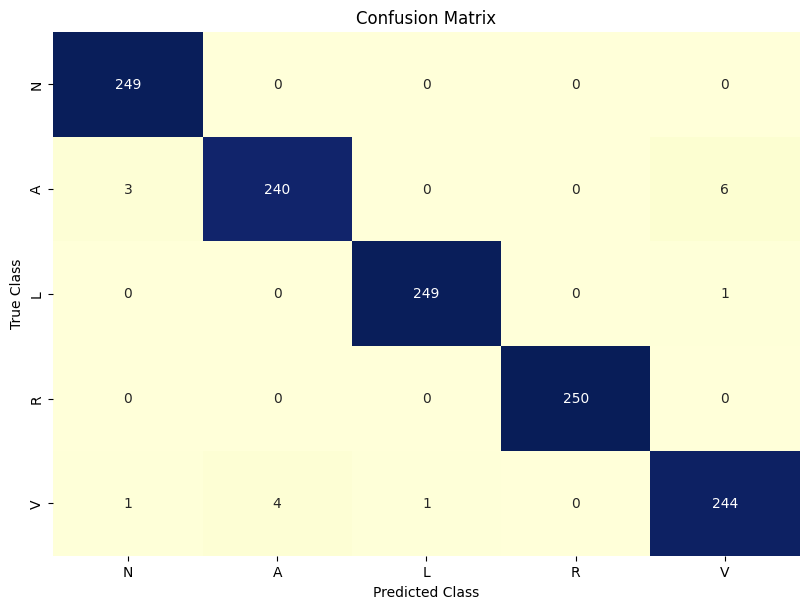

In [26]:
plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()